In [0]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

from tensorflow.examples.tutorials.mnist import input_data

In [2]:
mnist = input_data.read_data_sets(".", one_hot=True)

Extracting ./train-images-idx3-ubyte.gz
Extracting ./train-labels-idx1-ubyte.gz
Extracting ./t10k-images-idx3-ubyte.gz
Extracting ./t10k-labels-idx1-ubyte.gz


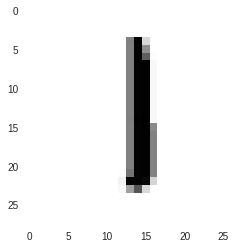

In [3]:
plt.figure().gca().grid(False)
plt.imshow(mnist.train.images[12].reshape(28, 28), cmap="Greys")

In [0]:
def discriminator(images, reuse=False):
    if reuse:
        tf.get_variable_scope().resuse_variables()

    ####################### Convolutional Layer 1 ##############################
    d_w1 = tf.get_variable("d_w1", [5, 5, 1, 32],
                           initializer=
                           tf.truncated_normal_initializer(stddev=0.02))
    d_b1 = tf.get_variable("d_b1", [32],
                           initializer=tf.constant_initializer(0))
    d1 = tf.nn.conv2d(input=images, filter=d_w1, strides=[1, 1, 1, 1],
                      padding="SAME")
    d1 = d1 + d_b1
    d1 = tf.nn.relu(d1)
    d1 = tf.nn.avg_pool(d1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1],
                        padding="SAME")

    ####################### Convolutional Layer 1 ##############################
    d_w2 = tf.get_variable("d_w2", [5, 5, 32, 64],
                           initializer=
                           tf.truncated_normal_initializer(stddev=0.02))
    d_b2 = tf.get_variable("d_b2", [32],
                           initializer=tf.constant_initializer(0))
    d2 = tf.nn.conv2d(input=images, filter=d_w2, strides=[1, 1, 1, 1],
                      padding="SAME")
    d2 = d2 + d_b2
    d2 = tf.nn.relu(d2)
    d2 = tf.nn.avg_pool(d1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1],
                        padding="SAME")
    ########################### Dense Layer 1 ##################################
    d_w3 = tf.get_variable("d_w3", [7 * 7 * 64, 1024],
                           initializer=
                           tf.truncated_normal_initializer(stddev=0.02))
    d_b3 = tf.get_variable("d_b3", [1024],
                            initializer=tf.constant_initializer(0))
    # flatten
    d3 = tf.reshape(d2, [-1, 7 * 7 * 64])
    d3 = tf.matmul(d3, d_w3) + d_b3
    d3 = tf.nn.relu(d3)
    ########################### Dense Layer 2 ##################################
    d_w4 = tf.get_variable("d_w4", [1024, 1],
                           initializer=
                           tf.truncated_normal_initializer(stddev=0.02))
    d_b4 = tf.get_variable("d_b4", [1],
                            initializer=tf.constant_initializer(0))
    d4 = tf.matmul(d3, d_w4) + d_b4
    d4 = tf.nn.relu(d4)
    # this is unscaled, so it's not probability or something
    return d4

In [0]:
def generator(z, batch_size, z_dim, reuse=False):
    """ Takes in random values, and generates images """
    if reuse:
        tf.get_variable_scope().reuse_variables()
    ################### Dense Layer 1 + Batch Normalization ####################
    g_w1 = tf.get_variable("g_w1", [z_dim, 3136], dtype=tf.float32,
                    initializer=tf.truncated_normal_initializer(stddev=0.02))
    g_b1 = tf.get_variable("g_b1", [3136],
                    initializer=tf.truncated_normal_initializer(stddev=0.02))
    g1 = tf.matmul(z, g_w1) + g_b1
    g1 = tf.reshape(g1, [-1, 56, 56, 1])
    g1 = tf.contrib.layers.batch_norm(g1, epsilon=1e-5, scope="bn1")
    g1 = tf.nn.relu(g1)

    ############## Convolutional Layer 1  + Batch Normalization ################

    g_w2 = tf.get_variable("g_w2", [3, 3, 1, z_dim/2], dtype=tf.float32,
                    initializer=tf.truncated_normal_initializer(stddev=0.02))
    g_b2 = tf.get_variable("g_b2", [z_dim/2],
                    initializer=tf.truncated_normal_initializer(stddev=0.02))
    g2 = tf.nn.conv2d(g1, g_w2, strides=[1, 2, 2, 1], padding="SAME")
    g2 = g2 + g_b2
    g2 = tf.contrib.layers.batch_norm(g2, epsilon=1e-5, scope="bn2")
    g2 = tf.nn.relu(g2)
    g2 = tf.image.resize_images(g2, [56, 56])

    ############## Convolutional Layer 2  + Batch Normalization ################
    g_w3 = tf.get_variable("g_w3", [3, 3, z_dim/2, z_dim/4], dtype=tf.float32,
                    initializer=tf.truncated_normal_initializer(stddev=0.02))
    g_b3 = tf.get_variable("g_b3", [z_dim/4],
                    initializer=tf.truncated_normal_initializer(stddev=0.02))
    g3 = tf.nn.conv2d(g2, g_w3, strides=[1, 2, 2, 1], padding="SAME")
    g3 = g3 + g_b3
    g3 = tf.contrib.layers.batch_norm(g3, epsilon=1e-5, scope="bn3")
    g3 = tf.nn.relu(g3)
    g3 = tf.image.resize_images(g3, [56, 56])

    ############## Convolutional Layer 3  + Batch Normalization ################
    g_w4 = tf.get_variable("g_w4", [1, 1, z_dim/4, 1], dtype=tf.float32,
                    initializer=tf.truncated_normal_initializer(stddev=0.02))
    g_b4 = tf.get_variable("g_b4", [1],
                    initializer=tf.truncated_normal_initializer(stddev=0.02))
    g4 = tf.nn.conv2d(g3, g_w4, strides=[1, 2, 2, 1], padding="SAME")
    g4 = g4 + g_b4
    # output dimensions: batch_size x 28 x 28 x 1
    # the reason we're taking sigmoid is to have crispier image
    g4 = tf.nn.sigmoid(g4)
    return g4

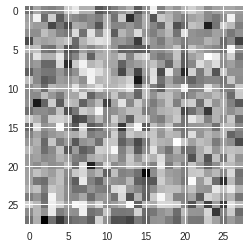

In [27]:
def print_random_image():
    z_dimensions = 100
    z_placeholder = tf.placeholder(tf.float32, shape=[None, z_dimensions])
    noisy_image = generator(z_placeholder, 1, z_dimensions)
    z_batch = np.random.normal(0, 1, [1, z_dimensions])
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        generated_image = sess.run(noisy_image, feed_dict={z_placeholder: z_batch})
        generated_image = generated_image.reshape([28, 28])
        plt.imshow(generated_image, cmap="Greys")
print_random_image()

In [0]:
tf.reset_default_graph()